In [1]:
import sys
sys.path.append("..")
from trends_core3d import *
from diag1d import *
import matplotlib.pyplot as plt
from intake import open_catalog
import dask
import cartopy.crs as ccrs
import matplotlib

/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/intake/source/discovery.py:46: UserWarning: Plugin name collision for "netcdf" from
    /net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/intake_iris/netcdf.py
and
    /net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


# Custom part for the ECV evaluator to read in the data 

In [2]:
# Here I use Python Intake for managing the reading of several datasets
cat = open_catalog('/home/crezees/datacatalogues/other/sm_catalog.yml')
print(list(cat))

['era_interim_land', 'satellite_soil_moisture', 'esa_cci_sm_combined_v05.0_preliminary', 'reanalysis_era5_single_levels', 'reanalysis_uerra_europe_soil_levels_uerra_harmonie']


In [3]:
# Read in CDS satellite soil moisture dataset
mydat = cat['esa_cci_sm_combined_v05.0_preliminary']

# Although this method is called to_dask() it returns a Xarray dataset
mydat = mydat.to_dask()

# Reduce data size a little by taking every tenth grid cell in lat and in lon direction
mydat = mydat.sm[:,:,:]#TODO put back

mydat = mydat.sel({'time' : slice('1992','2018')}) # Select from 1979

# Since the operations are performed over the time axis, it is important to have only one chunk along the time axis. Other chunk-sizes should be choosen depending on number of cores available
mydat = mydat.chunk({'time': -1, 'lat' : 360, 'lon' : 720})

# Print the object to check chunksizes
print(mydat)

<xarray.DataArray 'sm' (time: 312, lat: 720, lon: 1440)>
dask.array<shape=(312, 720, 1440), dtype=float64, chunksize=(312, 360, 720)>
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
  * time     (time) datetime64[ns] 1992-01-16 1992-02-15 ... 2017-12-16
Attributes:
    long_name:        Volumetric Soil Moisture
    units:            m3 m-3
    _CoordinateAxes:  time lat lon


/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [4]:
# Compute
mydat = mydat.compute(scheduler='processes')

In [5]:
# Some plotting parameters
# Note that these colormaps are colorblind friendly: https://github.com/matplotlib/matplotlib/issues/7081/
cmap_values = matplotlib.cm.get_cmap('YlOrBr')
cmap_diverging = matplotlib.cm.get_cmap('RdYlBu')

cmap_diverging.set_bad(color='grey')
cmap_values.set_bad(color='grey')

# Handle the data gaps

In [6]:
# Get valid fraction for each year
validfraction_peryear = mydat.groupby('time.year').reduce(validfrac_along_axis,'time').compute()

In [7]:
# Calculate yearly means
yearmean = mydat.groupby('time.year').mean('time').compute()

/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
# Now mask on a per-grid-point basis the years where valid fraction <= 0.8
yearmean = yearmean.where(validfraction_peryear > 0.8)

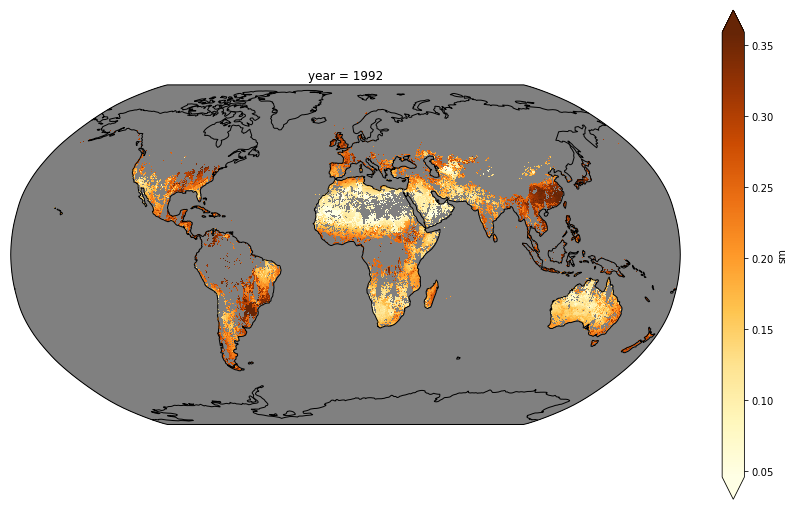

In [9]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
yearmean[0].plot(ax=ax, transform=ccrs.PlateCarree(),robust=True, cmap=cmap_values)
ax.coastlines()

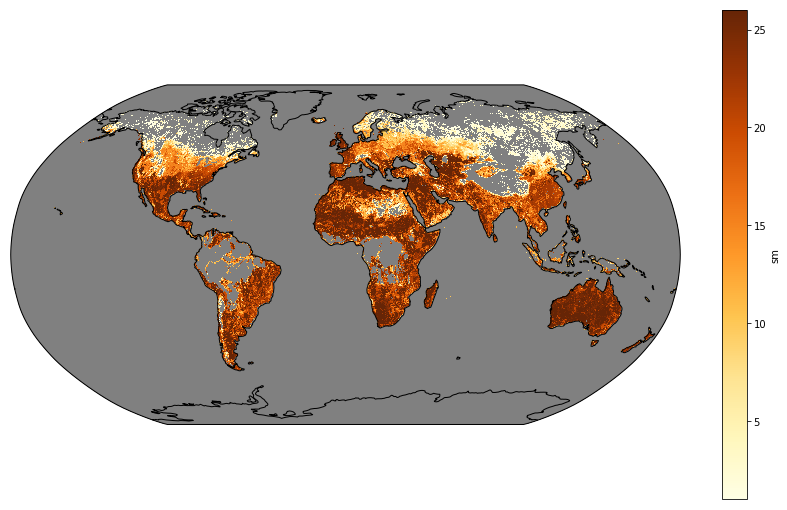

In [10]:
nvalid_years = (validfraction_peryear > .8).sum('year')
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
nvalid_years.where(nvalid_years > 0).plot(ax=ax, transform=ccrs.PlateCarree(),robust=True,cmap=cmap_values)
ax.coastlines()

In [11]:
valid_mask = (nvalid_years > 20).to_dataset() # Convert to DataSet for broadcasting
valid_mask = xr.broadcast(valid_mask,yearmean)[0]
yearmean = yearmean.where(valid_mask)
yearmean = yearmean.sm # Convert back to DataArray

> Some functions expect the 'time' coordinate to be available. 
> the groupby() operation changes the name of the time coordinate to 
> to become the 'year' coordinate, therefore, here it is changed back. 


# Linear trend

In [12]:
yearmean = yearmean.rename({'year' : 'time'})

lintrend,linpvalue = linear_trend(yearmean)
lintrend = lintrend.compute()   # Force computation
linpvalue = linpvalue.compute() # Force computation

# Linear trend (only 'significant')

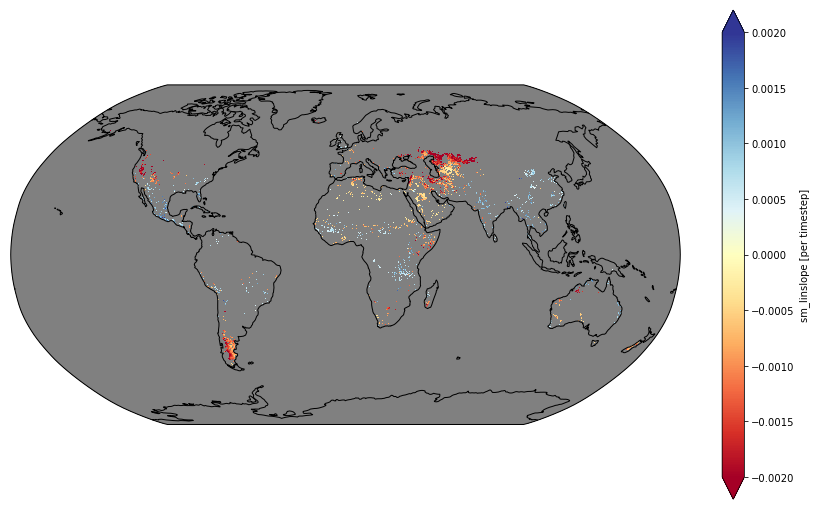

In [13]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
lintrend.where((linpvalue < 0.05)).plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cmap_diverging,vmin=-0.002,vmax=0.002)
ax.coastlines()

# Theilsen slope

/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


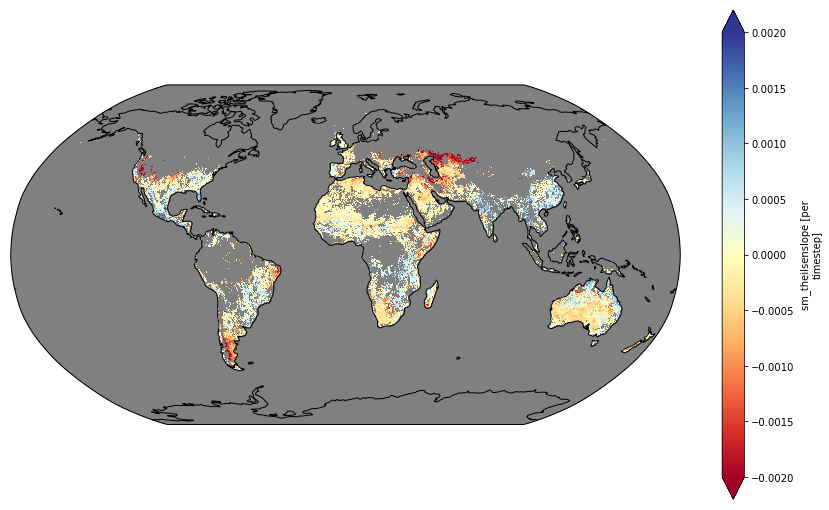

In [14]:
mydat = mydat.chunk({'time': -1, 'lat' : 36, 'lon' : 72})
theilsen_slope = theilsen_trend(yearmean)
theilsen_slope = theilsen_slope.compute(num_workers=16)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
theilsen_slope.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-0.002,vmax=0.002, cmap=cmap_diverging)
ax.coastlines()

# Mann-Kendall trend test

In [15]:
mk_result = mannkendall(yearmean).compute() # Like this the computation is forced.

/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


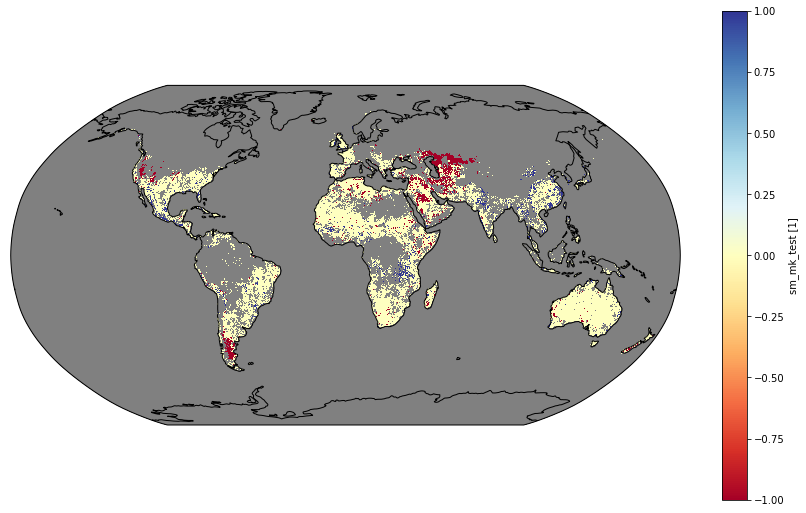

In [16]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
mk_result.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap=cmap_diverging)
ax.coastlines()

In [17]:
std,acf,nstar = weatherhead(yearmean,trend_magnitude=.001)

../diag1d.py:62: RuntimeWarning: divide by zero encountered in true_divide
  (1 + acf_res) / (1 - acf_res))**.5)**(2. / 3.)
../diag1d.py:62: RuntimeWarning: invalid value encountered in multiply
  (1 + acf_res) / (1 - acf_res))**.5)**(2. / 3.)
/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/net/exo/landclim/crezees/conda/envs/mpqb/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


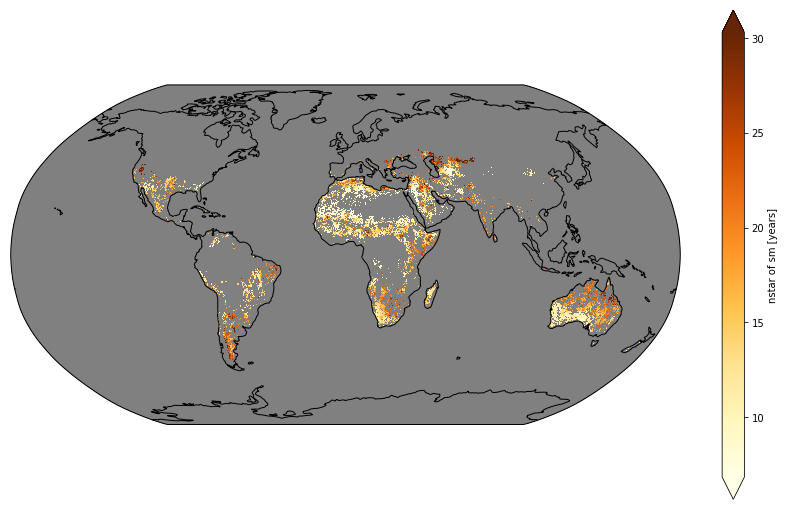

In [18]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
nstar.plot(ax=ax, transform=ccrs.PlateCarree(),robust=True,cmap=cmap_values)
ax.coastlines()

# Remarks
This example notebook was created for demonstrating the functionality available in this trend framework. A good knowledge of both the dataset and the specific trend algorithm is essential for interpreting correctly the outcome of different trend tests.

# Data acknowledgement and references

The dataset that was used to create this example notebook was provided by the 'ESA CCI SM project' and is available on [this link](https://www.esa-soilmoisture-cci.org/) after registration and acceptance of the 'Terms and Conditions of data usage, and Personal Data Privacy Policy Statement'.

- Dorigo, W.A., Wagner, W., Albergel, C., Albrecht, F., Balsamo, G., Brocca, L., Chung, D., Ertl, M., Forkel, M., Gruber, A., Haas, E., Hamer, D. P. Hirschi, M., Ikonen, J., De Jeu, R. Kidd, R. Lahoz, W., Liu, Y.Y., Miralles, D., Lecomte, P. (2017). ESA CCI Soil Moisture for improved Earth system understanding: State-of-the art and future directions. In Remote Sensing of Environment, 2017, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2017.07.001.
- Gruber, A., Dorigo, W. A., Crow, W., Wagner W. (2017). Triple Collocation-Based Merging of Satellite Soil Moisture Retrievals. IEEE Transactions on Geoscience and Remote Sensing. PP. 1-13. 10.1109/TGRS.2017.2734070.
- Liu, Y.Y., Dorigo, W.A., Parinussa, R.M., de Jeu, R.A.M. , Wagner, W., McCabe, M.F., Evans, J.P., van Dijk, A.I.J.M. (2012). Trend-preserving blending of passive and active microwave soil moisture retrievals, Remote Sensing of Environment, 123, 280-297, doi: 10.1016/j.rse.2012.03.014.